In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from matplotlib_venn import venn3, venn3_circles

import re
import logging
import itertools
import unicodedata
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import spacy
# import contractions

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from IPython.display import Markdown as md


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

C:\Users\Nikhil\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df1=pd.read_csv('malignant_comment_train.csv')

In [3]:
df1.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df1.shape

(159571, 8)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
df1.nunique()

id                  159571
comment_text        159571
malignant                2
highly_malignant         2
rude                     2
threat                   2
abuse                    2
loathe                   2
dtype: int64

In [7]:
df1['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [8]:
df1.describe().T


,count,mean,std,min,25%,50%,75%,max
malignant,159571.0,0.095844,0.294379,0.0,0.0,0.0,0.0,1.0
highly_malignant,159571.0,0.009996,0.099477,0.0,0.0,0.0,0.0,1.0
rude,159571.0,0.052948,0.223931,0.0,0.0,0.0,0.0,1.0
threat,159571.0,0.002996,0.054650,0.0,0.0,0.0,0.0,1.0
abuse,159571.0,0.049364,0.216627,0.0,0.0,0.0,0.0,1.0
loathe,159571.0,0.008805,0.093420,0.0,0.0,0.0,0.0,1.0


In [9]:
df1.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [10]:
plt.style.use("seaborn-pastel")
def category_percentage(df):
    df['clean'] = np.where((df['malignant']==0) & (df['highly_malignant']==0) & (df['rude']==0) & (df['threat']==0) & (df['abuse']==0) & (df['loathe']==0), 1,0)
    
    categories = ['malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe', 'clean']
    plot_data = df[categories].mean()*100

    plt.figure(figsize=(10,5))
    plt.title("percentage records by category")
    sns.barplot(x=plot_data.index, y = plot_data.values)
    plt.show()
    
    return

def corr_between_labels(df):
    plt.figure(figsize=(15,8))
    plt.title("correlation between toxic categories")
    sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
    plt.show()
    return 

## Gram statistics
def gram_analysis(data,gram):
    stop_words_set = set(stopwords.words('english'))
    tokens=[t for t in data.lower().split(" ") if t!="" if t not in stop_words_set]
    ngrams=zip(*[tokens[i:] for i in range(gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

def gram_freq(df, gram, categ_col, text_col):
    category_text = " ".join(df[df[categ_col]==1][text_col].sample(200).values)
    toks = gram_analysis(category_text, gram)
    tok_freq = pd.DataFrame(data=[toks, np.ones(len(toks))]).T.groupby(0).sum().reset_index()
    tok_freq.columns = ['token','frequency']
    tok_freq = tok_freq.sort_values(by='frequency',ascending=False)
    
    plt.figure(figsize=(10,8))
    plt.title("{} most common tokens".format(categ_col))
    sns.barplot(x='token', y='frequency', data=tok_freq.iloc[:30])
    plt.xticks(rotation=90)
    plt.show()
    
    return 

def avg_word_len_plot(df):
    # word distribution across categories
    df['punct_count'] = df['comment_text'].apply(lambda x : len([a for a in x if a in string.punctuation]))
    df['avg_word_length'] = df['comment_text'].apply(lambda x : np.round(np.mean([len(a) for a in x.split()])))
    
    clean = df[df['clean']==1].avg_word_length.value_counts().reset_index()
    clean.columns = ['length', 'frequency']
    print("clean comments max token length : {}".format(max(clean.length)))
    clean = clean.sort_values(by='length')
    plt.figure(figsize=(20,7))
    plt.title("Average word length - clean comments")
    sns.barplot(x=clean.length, y=clean.frequency)
    plt.xticks(rotation = 90)
    plt.show()
    
    toxic = df[df['clean']==0].avg_word_length.value_counts().reset_index()
    toxic.columns = ['length', 'frequency']
    print("toxic comments max token length : {}".format(max(toxic.length)))
    toxic = toxic.sort_values(by='length')
    plt.figure(figsize=(20,7))
    plt.title("Average word length -toxic comments (all forms)")
    sns.barplot(x=toxic.length, y=toxic.frequency)
    plt.xticks(rotation = 90)
    plt.show()
    
    return 

def generate_wordclouds(df, text_col, categ_col):
    df['clean'] = np.where((df['malignant']==0) & (df['highly_malignant']==0) & (df['rude']==0) & (df['threat']==0) & (df['abuse']==0) & (df['loathe']==0), 1,0)
    
    if categ_col=='all_toxic':
        category_text = df[df['clean']!=1][text_col].values
        
    else:
        category_text = df[df[categ_col]==1][text_col].values
               
    plt.figure(figsize=(15,8))
    wc = WordCloud(background_color="black", 
                   max_words=5000, 
                   stopwords=STOPWORDS, 
                   collocations=False,
                   max_font_size= 40)
    wc.generate(" ".join(category_text))
    plt.title("{} word cloud".format(categ_col), fontsize=20)
    # plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
    plt.axis('off')
    
    plt.show()
    
    return 



def meta_data_analysis(df, text_col):
    meta_df = pd.DataFrame()
    meta_df['punctuations'] = df[text_col].apply(lambda x : len([a for a in str(x) if a in string.punctuation]))
    meta_df['hashtags'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("#")]))
    meta_df['usernames'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("@")]))
    meta_df['stop_words'] = df[text_col].apply(lambda x : len([a for a in x.lower().split() if a in STOPWORDS]))
    meta_df['upper_case_words'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.isupper()]))
    meta_df['urls'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith(tuple(['http', 'www']))]))
    meta_df['word_count'] = df[text_col].apply(lambda x : len(x.split()))
    meta_df['distinct_word_count'] = df[text_col].apply(lambda x : len(set(x.split())))
    meta_df['clean'] = df['clean'].copy()
    
    return meta_df

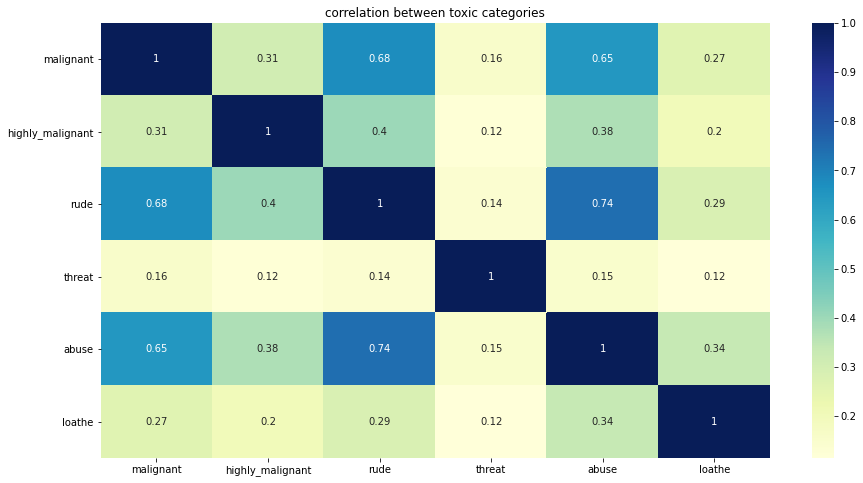

In [11]:
corr_between_labels(df1)

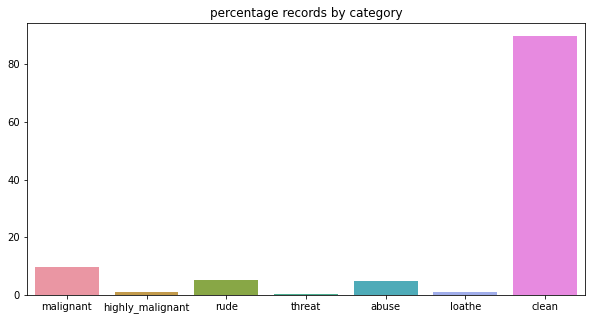

89.83% of the comments are clean i.e., non-toxic


In [12]:
category_percentage(df1)
print("{}% of the comments are clean i.e., non-toxic".format(np.round(100*df1['clean'].sum()/df1.shape[0],2)))
perc_clean_data = np.round(100*df1['clean'].sum()/df1.shape[0],2)

clean comments max token length : 709.0


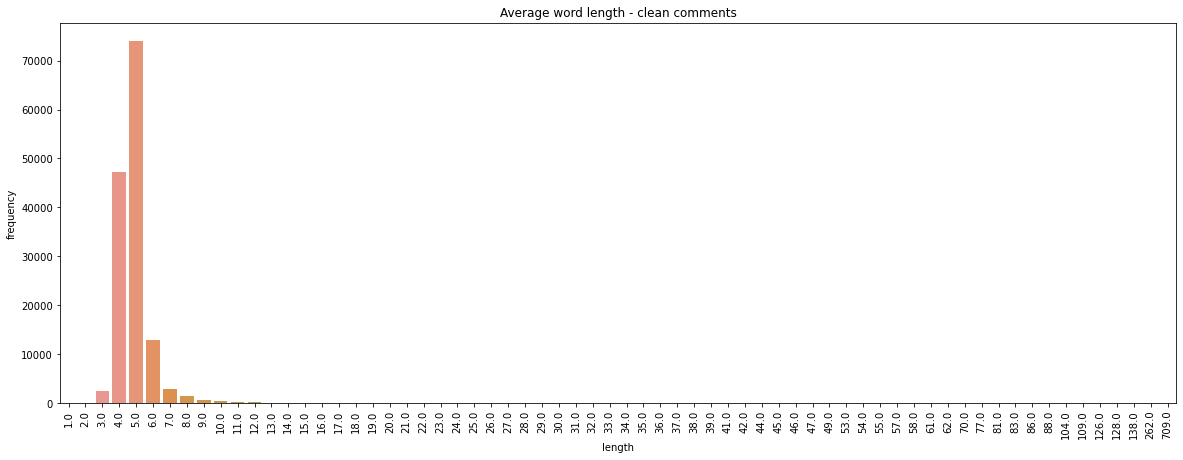

toxic comments max token length : 1655.0


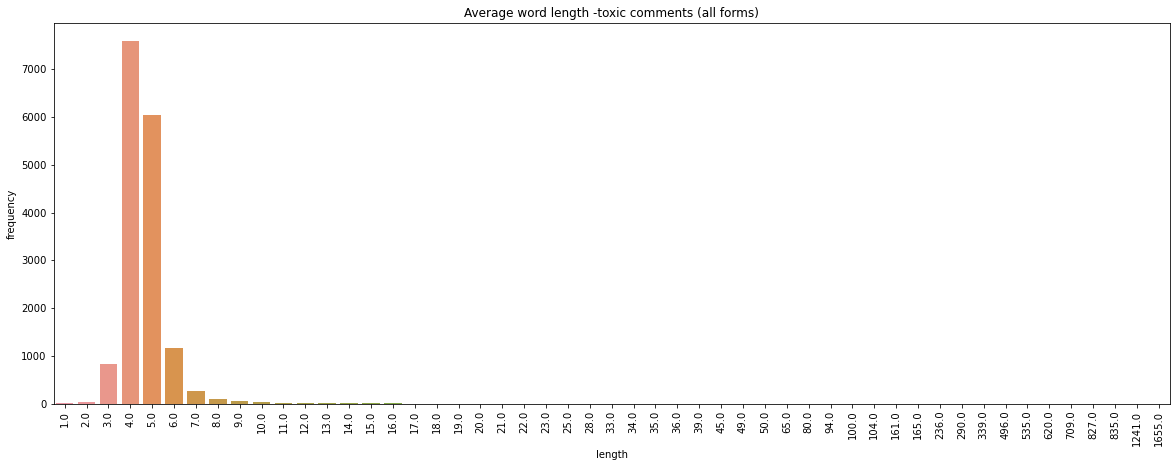

In [13]:
avg_word_len_plot(df1)


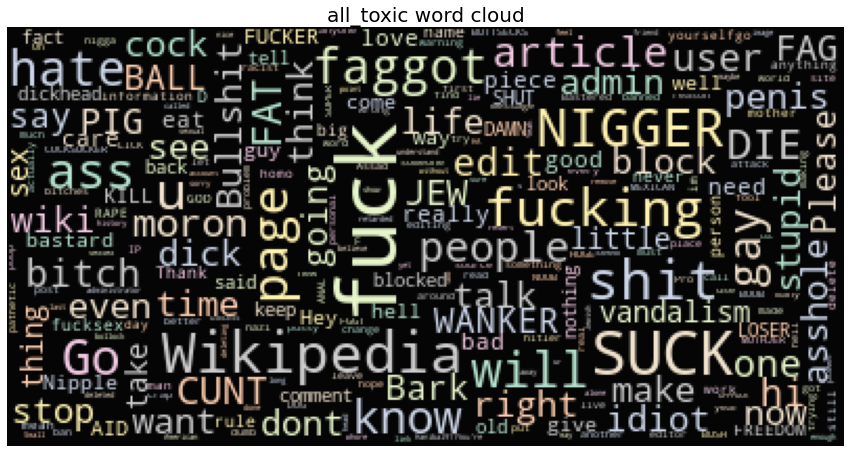

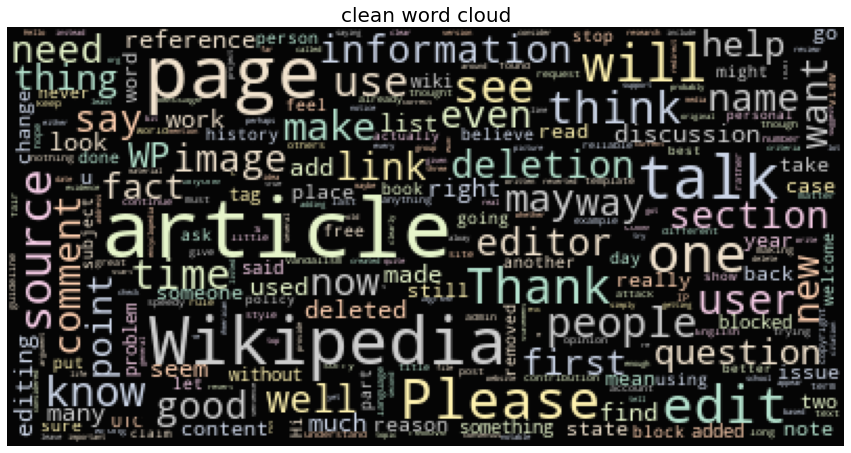

In [14]:
from wordcloud import WordCloud, STOPWORDS
generate_wordclouds(df1, 'comment_text', 'all_toxic')
generate_wordclouds(df1, 'comment_text', 'clean')

In [15]:
## Text cleaning

class TextCleaningUtils:
    '''
        This class contains implementations of various text cleaning operations (Static Methods)
    '''
    @staticmethod
    def expand_abbreviations(text):
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"there's", "there is", text)
        text = re.sub(r"We're", "We are", text)
        text = re.sub(r"That's", "That is", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"they're", "they are", text)
        text = re.sub(r"Can't", "Cannot", text)
        text = re.sub(r"wasn't", "was not", text)
        text = re.sub(r"don\x89Ûªt", "do not", text)
        text= re.sub(r"aren't", "are not", text)
        text = re.sub(r"isn't", "is not", text)
        text = re.sub(r"What's", "What is", text)
        text = re.sub(r"haven't", "have not", text)
        text = re.sub(r"hasn't", "has not", text)
        text = re.sub(r"There's", "There is", text)
        text = re.sub(r"He's", "He is", text)
        text = re.sub(r"It's", "It is", text)
        text = re.sub(r"You're", "You are", text)
        text = re.sub(r"I'M", "I am", text)
        text = re.sub(r"shouldn't", "should not", text)
        text = re.sub(r"wouldn't", "would not", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"i'm", "I am", text)
        text = re.sub(r"I\x89Ûªm", "I am", text)
        text = re.sub(r"I'm", "I am", text)
        text = re.sub(r"Isn't", "is not", text)
        text = re.sub(r"Here's", "Here is", text)
        text = re.sub(r"you've", "you have", text)
        text = re.sub(r"you\x89Ûªve", "you have", text)
        text = re.sub(r"we're", "we are", text)
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"we've", "we have", text)
        text = re.sub(r"it\x89Ûªs", "it is", text)
        text = re.sub(r"doesn\x89Ûªt", "does not", text)
        text = re.sub(r"It\x89Ûªs", "It is", text)
        text = re.sub(r"Here\x89Ûªs", "Here is", text)
        text = re.sub(r"who's", "who is", text)
        text = re.sub(r"I\x89Ûªve", "I have", text)
        text = re.sub(r"y'all", "you all", text)
        text = re.sub(r"can\x89Ûªt", "cannot", text)
        text = re.sub(r"would've", "would have", text)
        text = re.sub(r"it'll", "it will", text)
        text = re.sub(r"we'll", "we will", text)
        text = re.sub(r"wouldn\x89Ûªt", "would not", text)
        text = re.sub(r"We've", "We have", text)
        text = re.sub(r"he'll", "he will", text)
        text = re.sub(r"Y'all", "You all", text)
        text = re.sub(r"Weren't", "Were not", text)
        text = re.sub(r"Didn't", "Did not", text)
        text = re.sub(r"they'll", "they will", text)
        text = re.sub(r"DON'T", "DO NOT", text)
        text = re.sub(r"That\x89Ûªs", "That is", text)
        text = re.sub(r"they've", "they have", text)
        text = re.sub(r"they'd", "they would", text)
        text = re.sub(r"i'd", "I would", text)
        text = re.sub(r"should've", "should have", text)
        text = re.sub(r"You\x89Ûªre", "You are", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"Don\x89Ûªt", "Do not", text)
        text = re.sub(r"i'll", "I will", text)
        text = re.sub(r"weren't", "were not", text)
        text = re.sub(r"They're", "They are", text)
        text = re.sub(r"Can\x89Ûªt", "Cannot", text)
        text = re.sub(r"you\x89Ûªll", "you will", text)
        text = re.sub(r"I\x89Ûªd", "I would", text)
        text = re.sub(r"let's", "let us", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"you're", "you are", text)
        text = re.sub(r"i've", "I have", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"i'll", "I will", text)
        text = re.sub(r"doesn't", "does not",text)
        text = re.sub(r"i'd", "I would", text)
        text = re.sub(r"didn't", "did not", text)
        text = re.sub(r"ain't", "am not", text)
        text = re.sub(r"you'll", "you will", text)
        text = re.sub(r"I've", "I have", text)
        text = re.sub(r"Don't", "do not", text)
        text = re.sub(r"I'll", "I will", text)
        text = re.sub(r"I'LL", "I will", text)
        text = re.sub(r"I'd", "I would", text)
        text = re.sub(r"Let's", "Let us", text)
        text = re.sub(r"you'd", "You would", text)
        text = re.sub(r"It's", "It is", text)
        text = re.sub(r"Ain't", "am not", text)
        text = re.sub(r"Haven't", "Have not", text)
        text = re.sub(r"Hadn't", "Had not", text)
        text = re.sub(r"Could've", "Could have", text)
        text = re.sub(r"youve", "you have", text)  
        text = re.sub(r"donå«t", "do not", text)  

        return text

    cleaning_regex_map = {
        'web_links': r'(?i)(?:(?:http(?:s)?:)|(?:www\.))\S+',
        'email': r'[\w.]+@\w+\.[a-z]{3}',
        'twitter_handles': r'[#@]\S+',
        'redundant_newlines': r'[\r|\n|\r\n]+',
        'redundant_spaces': r'\s\s+',
        'punctuations': r'[\.,!?;:]+',
#         'special_chars': r'[^a-zA-Z0-9\s\.,!?;:]+',
        'special_chars': r'[^a-zA-Z\s\.,!?;:]+'  ## removing nums
        
    }
    
    @staticmethod
    def clean_text_from_regex(text, text_clean_regex):
        '''
            Follow a particular cleaning expression, provided
            as an input by an user to clean the text.
        '''

        text = text_clean_regex.sub(' ', text).strip()
        return text
    
    @staticmethod
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    
    @staticmethod
    def remove_web_links(text):
        '''
            Removes any web link that follows a particular default expression,
            present in the text.
        '''

        web_links_regex = re.compile(TextCleaningUtils.cleaning_regex_map['web_links'])
        text = TextCleaningUtils.clean_text_from_regex(text, web_links_regex)
        return text
    
    @staticmethod
    def remove_email_addresses(text):
        '''
            Removes email addresses present in the text.
        '''

        email_regex = re.compile(TextCleaningUtils.cleaning_regex_map['email'])
        text = TextCleaningUtils.clean_text_from_regex(text, email_regex)
        return text
    
    @staticmethod
    def remove_twitter_handles(text):
        '''
            Removes any twitter handle present in the text.
        '''

        twitter_handles_regex = re.compile(TextCleaningUtils.cleaning_regex_map['twitter_handles'])
        text = TextCleaningUtils.clean_text_from_regex(text, twitter_handles_regex)
        return text
    
    @staticmethod
    def remove_emojis(text):
        emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text=emoji_clean.sub(r'',text)
        url_clean= re.compile(r"https://\S+|www\.\S+")
        text=url_clean.sub(r'',text)
        return text
    
    @staticmethod
    def remove_redundant_newlines(text):
        '''
            Removes any redundant new line present in the text.
        '''

        redundant_newlines_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_newlines'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_newlines_regex)
        return text
    
    @staticmethod
    def remove_redundant_spaces(text):
        '''
            Remove any redundant space provided as default,
            that is present in the text.
        '''

        redundant_spaces_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_spaces'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_spaces_regex)
        return text
    
    @staticmethod
    def remove_punctuations(text):
        '''
            Removes any punctuation that follows the default expression, in the text.
        '''

        remove_punctuations_regex = re.compile(TextCleaningUtils.cleaning_regex_map['punctuations'])
        text = TextCleaningUtils.clean_text_from_regex(text, remove_punctuations_regex)
        return text

    @staticmethod
    def remove_special_chars(text):
        '''
            Replace any special character provided as default,
            which is present in the text with space
        '''

        special_chars_regex = re.compile(TextCleaningUtils.cleaning_regex_map['special_chars'])
        text = TextCleaningUtils.clean_text_from_regex(text, special_chars_regex)
        return text

    @staticmethod
    def remove_exaggerated_words(text):
        '''
            Removes any exaggerated word present in the text.
        '''

        return ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))

    @staticmethod
    def replace_multiple_chars(text):
        '''
            Replaces multiple characters present in the text.
        '''

        char_list = ['.', '?', '!', '#', '$', '/', '@', '*', '(', ')', '+']
        final_text = ''
        for i in char_list:
            if i in text:
                pattern = "\\" + i + '{2,}'
                repl_str = i.replace("\\", "")
                text = re.sub(pattern, repl_str, text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def replace_sign(text):
        '''
            Replaces any sign with words like & with 'and', in the text.
        '''
        sign_list = {'&': ' and ', '/': ' or ', '\xa0': ' '}
        final_text = ''
        for i in sign_list:
            if i in text:
                text = re.sub(i, sign_list[i], text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def remove_accented_char(text):
        text = unicodedata.normalize('NFD', text) \
            .encode('ascii', 'ignore') \
            .decode("utf-8")
        return str(text)

    @staticmethod
    def replace_characters(text, replace_map):
        '''
            Replaces any character custom provided by an user.
        '''

        for char, replace_val in replace_map.items():
            text = text.replace(char, replace_val)
        return text
    
def clean_data(df,col_to_clean):
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_web_links)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_email_addresses)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_twitter_handles)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.expand_abbreviations)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_emojis)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_special_chars)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_spaces)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_punctuations)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_exaggerated_words)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_newlines)
    df[col_to_clean] = df[col_to_clean].astype(str)
    df[col_to_clean] = df[col_to_clean].str.lower()
    
    return df

In [16]:
df1 = clean_data(df1, 'comment_text')

clean comments max token length : 30.0


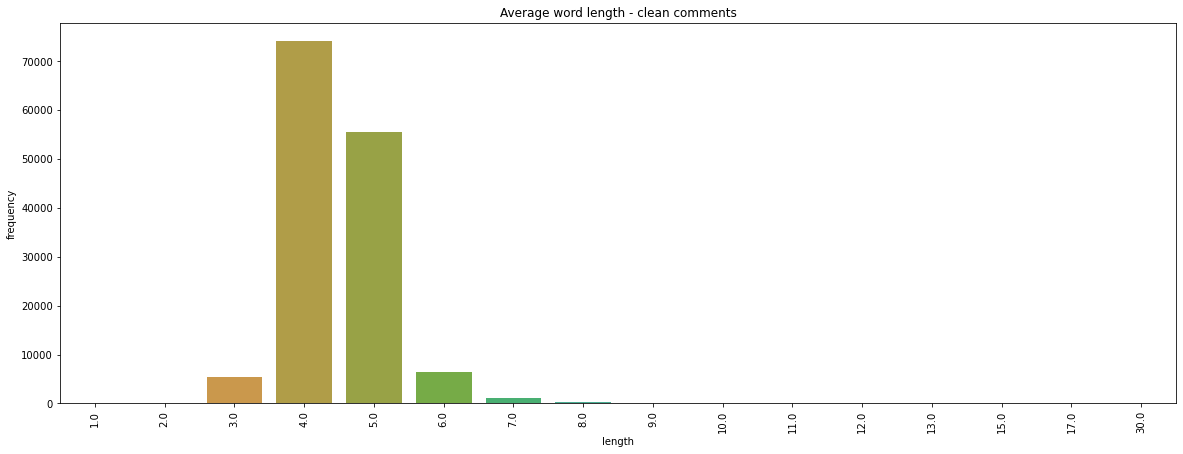

toxic comments max token length : 1240.0


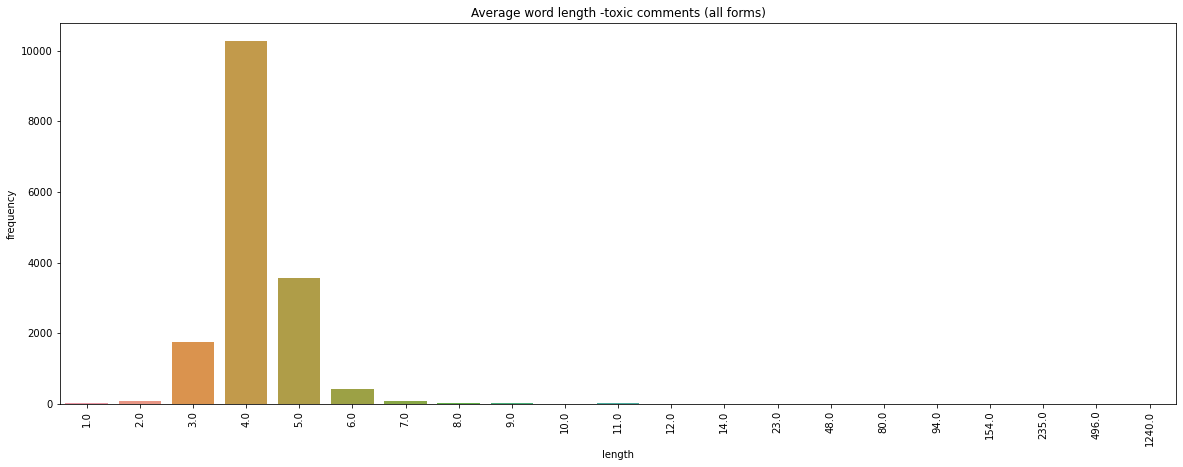

In [17]:
avg_word_len_plot(df1)

In [18]:
#Let's take a closer look at long words (>20 characters)
category_text = df1[df1['clean']!=1]['comment_text'].values
category_text = " ".join(category_text)
long_len_words = [word for word in category_text.split() if len(word)>20]
print("num of long length words in toxic(all forms) text : {}".format(len(long_len_words)))
long_len_words[:5]

num of long length words in toxic(all forms) text : 392


['foreverlosttinkerbell',
 'encyclopediadramatica',
 'hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha',
 'lolololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololol',
 'cuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcunti']

In [19]:
import nltk

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

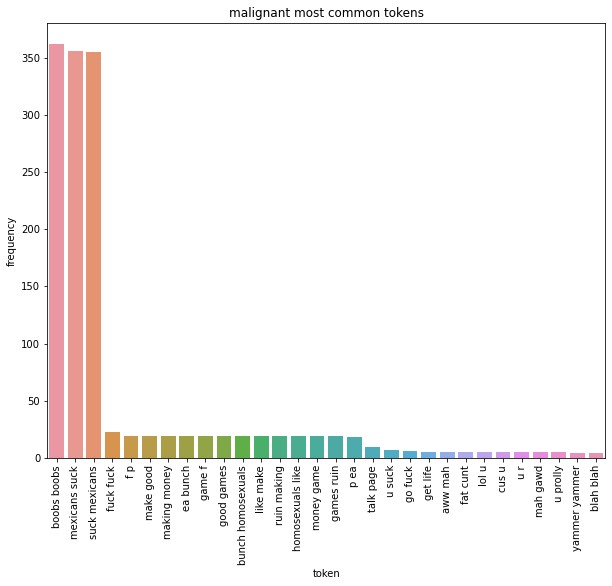

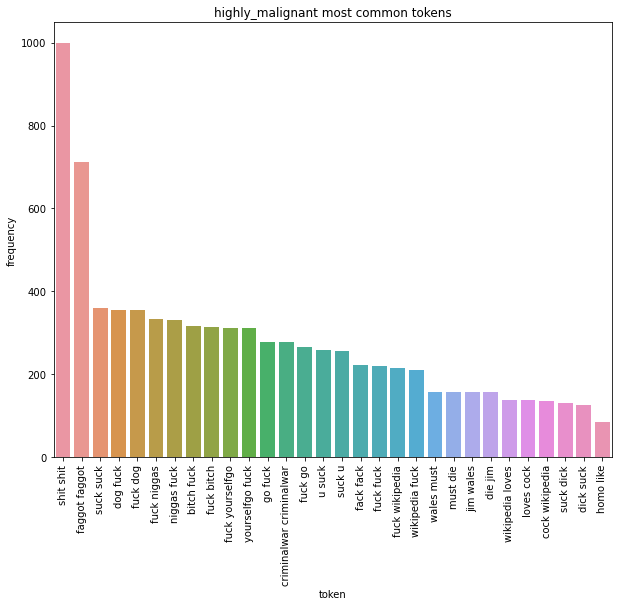

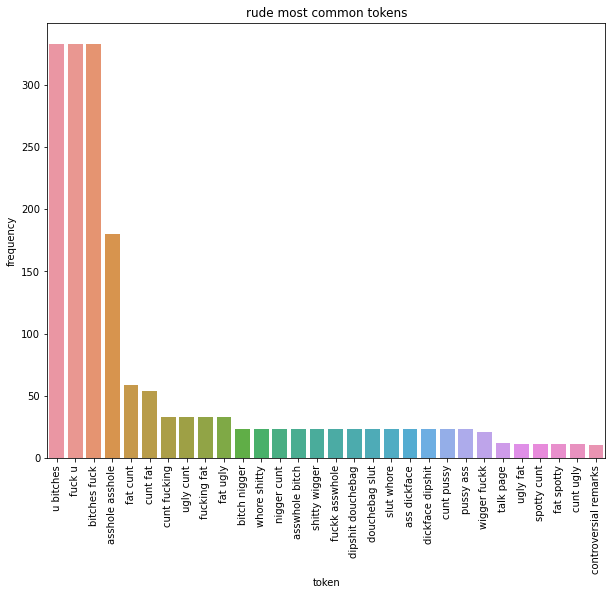

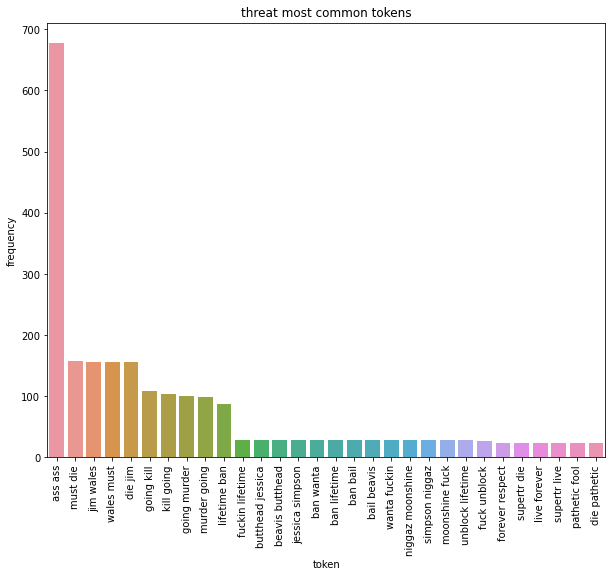

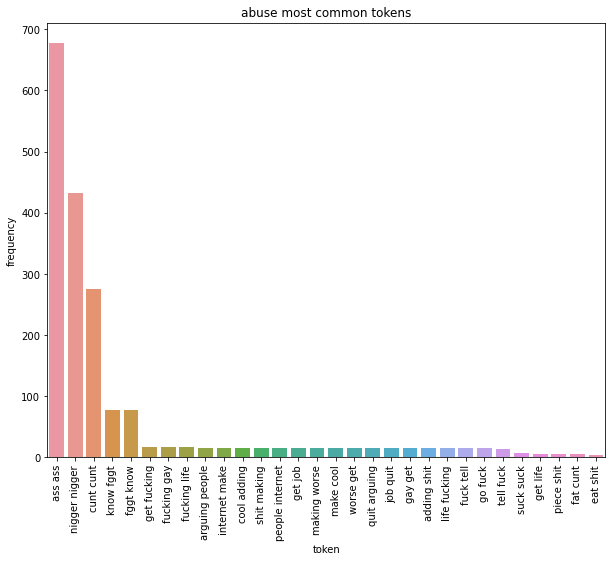

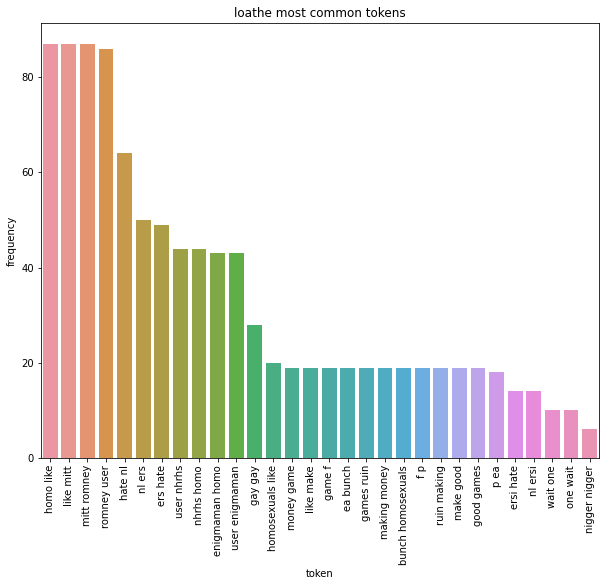

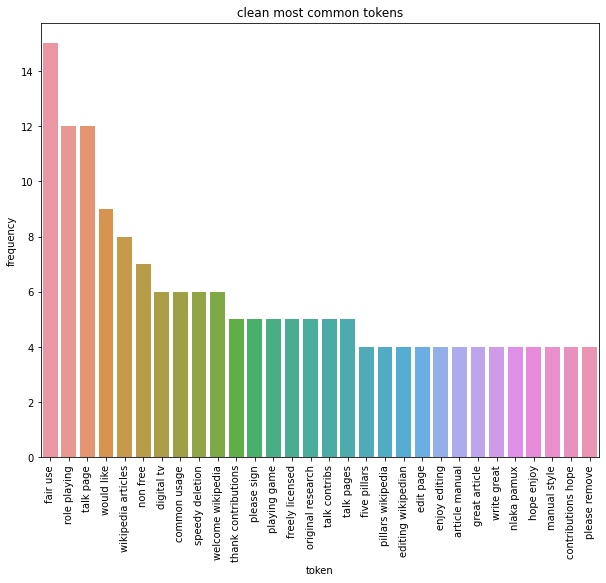

In [21]:
for i in ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe', 'clean']:
    gram_freq(df1,2, i, 'comment_text')

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

def text_transformation(text):
    lemm_words = " ".join([lemm.lemmatize(word) for word in text.split()])    
    return lemm_words
                        
df1['comment_text'] = df1['comment_text'].apply(text_transformation)

In [24]:
tr_df, val_df = train_test_split(df1, test_size=0.25, random_state=0)

In [25]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), analyzer='word', 
                                   strip_accents='unicode',token_pattern=r'\w{1,}', use_idf=1,
                                   smooth_idf=1,sublinear_tf=1)

# tfidf_vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3))
train_tfidf = tfidf_vectorizer.fit_transform(tr_df['comment_text'])
val_tfidf =  tfidf_vectorizer.transform(val_df['comment_text'])

target_category = []
aucs = []
for target in ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']:
    target_category.append(target)
    lr = LogisticRegression(C=2, class_weight='balanced', max_iter=1000)
    lr.fit(train_tfidf, tr_df[target])
    lr_val_pred = lr.predict(val_tfidf)
    print("model for {} category".format(target))
    auc_score = roc_auc_score(val_df[target], lr_val_pred)
    aucs.append(auc_score)
    print("validation auc : ", auc_score, "\n")
    print("model for {} category".format(target))
    print(confusion_matrix(val_df[target], lr_val_pred))
    print(classification_report(val_df[target], lr_val_pred))
    print('*************************************************************************')
    print('\n')
print("avg auc : ", np.mean(aucs))


model for malignant category
validation auc :  0.8948756160366648 

model for malignant category
[[34574  1471]
 [  652  3196]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     36045
           1       0.68      0.83      0.75      3848

    accuracy                           0.95     39893
   macro avg       0.83      0.89      0.86     39893
weighted avg       0.95      0.95      0.95     39893

*************************************************************************


model for highly_malignant category
validation auc :  0.9004451770301227 

model for highly_malignant category
[[38657   821]
 [   74   341]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     39478
           1       0.29      0.82      0.43       415

    accuracy                           0.98     39893
   macro avg       0.65      0.90      0.71     39893
weighted avg       0.99      0.98      0.98     39893



In [26]:
tfidf_vectorizer.get_feature_names()[0:20]


['aa',
 'aa aa',
 'aa aa bb',
 'aa aa requires',
 'aa aat',
 'aa aat defined',
 'aa according',
 'aa according commonplace',
 'aa accused',
 'aa accused disruption',
 'aa acupuncture',
 'aa acupuncture analgesia',
 'aa american',
 'aa american citizen',
 'aa armament',
 'aa armament admittedly',
 'aa article',
 'aa article better',
 'aa article say',
 'aa aspect']

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


In [28]:
# Creating classifiers with default parameters initially.
clf1 = MultinomialNB()
clf3 = LinearSVC()

In [29]:
def cross_validation_score(classifier, train_tfidf, tr_df):
    '''
    Iterate though each label and return the cross validation F1 and Recall score 
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for target in ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']:
        recall = cross_val_score(
            classifier, train_tfidf, tr_df[target], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, train_tfidf,
                             tr_df[target], cv=10, scoring='f1')
        methods.append([name, target, recall.mean(), f1.mean()])

    return methods

In [30]:
# Calculating the cross validation F1 and Recall score for our 3 baseline models.
methods1_cv = pd.DataFrame(cross_validation_score(clf1, train_tfidf, tr_df))

In [31]:
methods3_cv = pd.DataFrame(cross_validation_score(clf3, train_tfidf, tr_df))

In [32]:

# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods1_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,malignant,0.037392,0.072057
1,MultinomialNB,highly_malignant,0.000000,0.000000
2,MultinomialNB,rude,0.018945,0.037141
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,abuse,0.001017,0.002028
5,MultinomialNB,loathe,0.000000,0.000000
6,LinearSVC,malignant,0.563951,0.701024
7,LinearSVC,highly_malignant,0.125424,0.199843
8,LinearSVC,rude,0.611997,0.733284
9,LinearSVC,threat,0.070721,0.123655
